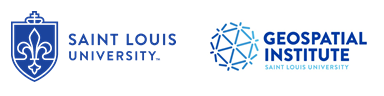

# Lab 03: Tour of Scikit-learn Algorithms Part 2
## GIS 5092: Applied Machine Learning for GIS and Remote Sensing (Fall 2021)
Course Instructor: **Dr. Vasit Sagan** (vasit.sagan@slu.edu)
Teaching Assistant: **Sourav Bhadra** (sourav.bhadra@slu.edu)  
[Join Slack Workspace for this class](https://join.slack.com/t/gis5092-fall21/shared_invite/zt-u9vpmzat-SB5sYNtaPWk3vW_Qbj8QRQ)

## Learning Objectives:

* Prepare training and testing dataset for classification
* Train classifiers using scikit-learn
* Apply a trained classifier to an image

# How to work with this Notebook?
Write your answers in places where you see **YOUR ANSWER HERE** within the **#### ... ####** comments. If there is a variable already declared and assigned a value of **None**, then just replace your code with the assigned **None**. If your answer is code, then use the Code cell, if its text, then use the Text cell. Save a copy of this notebook in your Lab Folder by replacing the STUDENT with your SURNAME in CAPS. Then Upload your deliverables (items listed at the end of this document) in Canvas.

---

# Classification with a larger sample size

In Part 2, you will perform a LULC task for the same image and study area, but the training sample now has a much larger sample size. You will find the ground truth label shapefile named as <code>lulc_labels_large.shp</code> in <code>lab3</code> folder. Use the same image (<code>LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite.tif</code>) you used before to extract reflectance information. Apply your best trained model to the <code>LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite_Small.tif</code> and visualize it as a map. Follow the key tasks:

1. Read image and shapefile
2. Consider the fact that there might be nodata in the image
3. Extract pixel value from each point
4. Remember to convert your data from 0 to 1
5. Encode your label data, i.e., text label to integer codes
6. Shuffle your data and split your data into train and test set
7. Train a **Random Forest** and **Support Vector Machine** classifier for the training set. Play around with the hyperparameters so that you get better accuracy in the test set
8. Apply the best performing model to the smaller image
9. Save the LULC map as a raster data in <code>lab3</code> folder as <code>LULC2.tif</code>
10. Create a map of LULC2.tif in ArcGIS Desktop or ArcGIS Pro 

**Notes:**
* Instead of 5 classes, you have to deal with 8 classes in <code>lulc_labels_large.shp</code>. The labels are: 'Agriculture', 'Barren', 'Developed', 'Forest', 'Herbaceous', 'Shrub', 'Water', 'Wetland'. So when you are encoding the texts into integer, be careful not to just copy paste from Part 1. Change codes wherever necessary.

In [45]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd


In [46]:
### YOUR ANSWER HERE ###

src = rasterio.open(r'C:\Users\syed_\OneDrive - Saint Louis University\Intro To Prog\lab3\data\LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite.tif')
# Assume img is the loaded image data
img = src.read()
img = img.astype(float)
img[img == np.float32(src.nodata)] = np.nan
print(type(img))

#img = img/65536

########################

<class 'numpy.ndarray'>


In [48]:

# Load the shapefile
points_large = gpd.read_file(r'C:\Users\syed_\OneDrive - Saint Louis University\Intro To Prog\lab3\data\lulc_labels_large.shp')



In [49]:


def extract_pixel_value_from_point(point_shape, image_src, image_np):
    


    
    # Empty dictionary to hold all the pixel values
    values_dict = {}
    
    # Loop through each point feature and populate the dict
    for i, point in enumerate(point_shape['geometry']):
        
        # Get the x and y coordinate
        x = point.xy[0][0]
        y = point.xy[1][0]
        
        # Get the associated row col number
        # based on the coordinate
        row, col = image_src.index(x, y)
        values = image_np[:, row, col]
        
        # Get the UID
        uid = point_shape.iloc[i, 0]
        
        # Populate the dictionary
        values_dict[uid] = values
        
    # Convert the dictionary to a pd dataframe
    values_df = pd.DataFrame(values_dict).T
    # Reset the index of the df
    values_df.reset_index(inplace=True)
    # Change the column names
    values_df.columns = ['UID', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    
    return values_df



In [50]:
# Calling extract_pixel_value_from_point function to extract pixel values
reflectance_large = extract_pixel_value_from_point(points_large, src, img)

#Convert data from 0 to 1
reflectance_large.iloc[:, 1:] = reflectance_large.iloc[:, 1:] / 65535.0
reflectance_large

,UID,B1,B2,B3,B4,B5,B6,B7
0,0,0.125963,0.127794,0.136522,0.137774,0.217853,0.225116,0.174472
1,1,0.132616,0.138643,0.153399,0.165270,0.223850,0.243259,0.196933
2,2,0.125566,0.128252,0.146761,0.138430,0.323964,0.229450,0.170443
3,3,0.124300,0.124819,0.130846,0.130175,0.203067,0.193729,0.154192
4,4,0.137819,0.140688,0.158328,0.163684,0.226230,0.225162,0.196948
...,...,...,...,...,...,...,...,...
9995,9995,0.125429,0.129458,0.142107,0.144457,0.271855,0.244297,0.178927
9996,9996,0.138766,0.148943,0.172595,0.200732,0.273274,0.327169,0.260838
9997,9997,0.126925,0.128893,0.142458,0.146487,0.231312,0.225925,0.177646
9998,9998,0.122362,0.124132,0.133730,0.132113,0.219364,0.205432,0.164111


In [51]:
# Joining
data = reflectance_large.join(points_large, on='UID', rsuffix='_')
data

,UID,B1,B2,B3,B4,B5,B6,B7,UID_,Label,geometry
0,0,0.125963,0.127794,0.136522,0.137774,0.217853,0.225116,0.174472,0,Wetland,POINT (693714.174 4347476.783)
1,1,0.132616,0.138643,0.153399,0.165270,0.223850,0.243259,0.196933,1,Agriculture,POINT (765867.104 4306413.218)
2,2,0.125566,0.128252,0.146761,0.138430,0.323964,0.229450,0.170443,2,Agriculture,POINT (639486.185 4254365.344)
3,3,0.124300,0.124819,0.130846,0.130175,0.203067,0.193729,0.154192,3,Forest,POINT (585087.231 4242592.508)
4,4,0.137819,0.140688,0.158328,0.163684,0.226230,0.225162,0.196948,4,Developed,POINT (718363.803 4275233.381)
...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.125429,0.129458,0.142107,0.144457,0.271855,0.244297,0.178927,9995,Forest,POINT (678262.408 4247215.022)
9996,9996,0.138766,0.148943,0.172595,0.200732,0.273274,0.327169,0.260838,9996,Agriculture,POINT (749399.748 4252238.676)
9997,9997,0.126925,0.128893,0.142458,0.146487,0.231312,0.225925,0.177646,9997,Developed,POINT (609949.843 4259599.361)
9998,9998,0.122362,0.124132,0.133730,0.132113,0.219364,0.205432,0.164111,9998,Forest,POINT (595608.875 4284576.990)


In [52]:
from sklearn.utils import shuffle
data = shuffle(data)

# We dont need all the columns, lets just keep the ones that we need
data = data[['Label', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']]
data

,Label,B1,B2,B3,B4,B5,B6,B7
202,Developed,0.121675,0.125154,0.137438,0.139239,0.204303,0.180301,0.158083
4198,Agriculture,0.130587,0.134829,0.150057,0.151263,0.282490,0.261265,0.196338
281,Wetland,0.124315,0.125017,0.134829,0.131167,0.225116,0.199557,0.156832
1307,Wetland,0.122850,0.124071,0.131533,0.129320,0.184894,0.156817,0.136065
8306,Agriculture,0.152224,0.166598,0.193210,0.227085,0.297688,0.325307,0.249805
...,...,...,...,...,...,...,...,...
1879,Developed,0.162234,0.184802,0.173373,0.191302,0.275593,0.254704,0.205997
8521,Developed,0.142077,0.146151,0.157748,0.165560,0.201877,0.200534,0.181888
5849,Wetland,0.124178,0.126650,0.139086,0.137270,0.228260,0.207813,0.162799
9937,Shrub,0.117906,0.120226,0.132433,0.129747,0.258015,0.186770,0.143984


In [53]:
# Create a clumn named 'Label_int' which has only 0 as values
data['Label_int'] = 0
data

,Label,B1,B2,B3,B4,B5,B6,B7,Label_int
202,Developed,0.121675,0.125154,0.137438,0.139239,0.204303,0.180301,0.158083,0
4198,Agriculture,0.130587,0.134829,0.150057,0.151263,0.282490,0.261265,0.196338,0
281,Wetland,0.124315,0.125017,0.134829,0.131167,0.225116,0.199557,0.156832,0
1307,Wetland,0.122850,0.124071,0.131533,0.129320,0.184894,0.156817,0.136065,0
8306,Agriculture,0.152224,0.166598,0.193210,0.227085,0.297688,0.325307,0.249805,0
...,...,...,...,...,...,...,...,...,...
1879,Developed,0.162234,0.184802,0.173373,0.191302,0.275593,0.254704,0.205997,0
8521,Developed,0.142077,0.146151,0.157748,0.165560,0.201877,0.200534,0.181888,0
5849,Wetland,0.124178,0.126650,0.139086,0.137270,0.228260,0.207813,0.162799,0
9937,Shrub,0.117906,0.120226,0.132433,0.129747,0.258015,0.186770,0.143984,0


In [54]:
# Perform the following operation
for i in range(data.shape[0]):
    label_txt = data.iloc[i, 0]
    
    if label_txt=='Water':
        data.iloc[i, -1] = 1
    elif label_txt=='Wetland':
        data.iloc[i, -1] = 2
    elif label_txt=='Developed':
        data.iloc[i, -1] = 3
    elif label_txt=='Forest':
        data.iloc[i, -1] = 4
    elif label_txt=='Agriculture':
        data.iloc[i, -1] = 5
    elif label_txt=='Barren':
        data.iloc[i, -1] = 6
    elif label_txt=='Herbaceous':
        data.iloc[i, -1] = 7
    elif label_txt=='Shrub':
        data.iloc[i, -1] = 8
        
data

,Label,B1,B2,B3,B4,B5,B6,B7,Label_int
202,Developed,0.121675,0.125154,0.137438,0.139239,0.204303,0.180301,0.158083,3
4198,Agriculture,0.130587,0.134829,0.150057,0.151263,0.282490,0.261265,0.196338,5
281,Wetland,0.124315,0.125017,0.134829,0.131167,0.225116,0.199557,0.156832,2
1307,Wetland,0.122850,0.124071,0.131533,0.129320,0.184894,0.156817,0.136065,2
8306,Agriculture,0.152224,0.166598,0.193210,0.227085,0.297688,0.325307,0.249805,5
...,...,...,...,...,...,...,...,...,...
1879,Developed,0.162234,0.184802,0.173373,0.191302,0.275593,0.254704,0.205997,3
8521,Developed,0.142077,0.146151,0.157748,0.165560,0.201877,0.200534,0.181888,3
5849,Wetland,0.124178,0.126650,0.139086,0.137270,0.228260,0.207813,0.162799,2
9937,Shrub,0.117906,0.120226,0.132433,0.129747,0.258015,0.186770,0.143984,8


In [55]:
train_size = int(data.shape[0] * 0.7)

X_train = data.iloc[:train_size, 1:-1]
y_train = data.iloc[:train_size, -1]
X_test = data.iloc[train_size:, 1:-1]
y_test = data.iloc[train_size:, -1]

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Conduct the random forest for different hyperparameters and
# calculate scores for each combination and note the value in the table

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Evaluate the model on the test data
rf_score = rf.score(X_test, y_test)
print(f'Random Forest Accuracy: {rf_score * 100:.2f}%')





Random Forest Accuracy: 81.27%


In [84]:

# Conduct the random forest for different hyperparameters and
# calculate scores for each combination and note the value in the table

rf = RandomForestClassifier(n_estimators=1000)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Evaluate the model on the test data
rf_score = rf.score(X_test, y_test)
print(f'Random Forest Accuracy: {rf_score * 100:.2f}%')


Random Forest Accuracy: 81.60%


In [58]:
# SVM
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the model to the training data
svc.fit(X_train, y_train)

# Evaluate the model on the test data
svc_score = svc.score(X_test, y_test)
print(f'SVM Accuracy: {svc_score * 100:.2f}%')


SVM Accuracy: 73.93%


In [59]:
# SVM
svc = SVC(kernel='rbf', C=1.0, random_state=42)

# Fit the model to the training data
svc.fit(X_train, y_train)

# Evaluate the model on the test data
svc_score = svc.score(X_test, y_test)
print(f'SVM Accuracy: {svc_score * 100:.2f}%')


SVM Accuracy: 81.17%


In [69]:
# Read the small image as rasterio src
src_small = rasterio.open('.\data\LC08_L2SP_024033_20201016_20201105_02_T1_SR_Composite_Small.tif')

# Convert the image into np array
img_small = src_small.read()
img_small = img_small.astype(float)
img_small[img_small == np.float64(src.nodata)] = np.nan

img_small = img_small/65536


# Print its shape
print(np.any(np.isinf(img_small)))
print(np.max(img_small))



False
nan


In [65]:
# First we need to move the n_channel dimension to the end
img_channel_last = np.moveaxis(img_small, 0, 2)

# Now check the shape
print(img_channel_last.shape)

(501, 501, 7)


In [70]:
# See that the n_channels (which is 7) is in the last position

# Now reshape the img from 3D to 2d
img_reshaped = img_channel_last.reshape(-1, 7)

# Check its shape
print(img_reshaped.shape)

print(np.any(np.isinf(img_reshaped)))
print(np.max(img_reshaped))


(251001, 7)
False
nan


In [71]:
img_reshaped = np.nan_to_num(img_reshaped)  # This replaces NaN values with 0


In [86]:
# Now let's predict all the values using the predict method
# Remember the resulting array would be a 1D array
lulc_1d = rf.predict(img_reshaped)

# Check it's shape
print(lulc_1d.shape)

(251001,)


In [87]:
# We have to convert the 1d predicted lulc values to a 2d array to
# get that as an image. Reshape it back to its original shape
lulc_2d = lulc_1d.reshape(img_small.shape[1], img_small.shape[2])
print(lulc_2d.shape)

(501, 501)


In [88]:

# is in the last dimension
img_channel_last = np.moveaxis(img_small, 0, 2)

# Now check the shape
print(img_channel_last.shape)

(501, 501, 7)


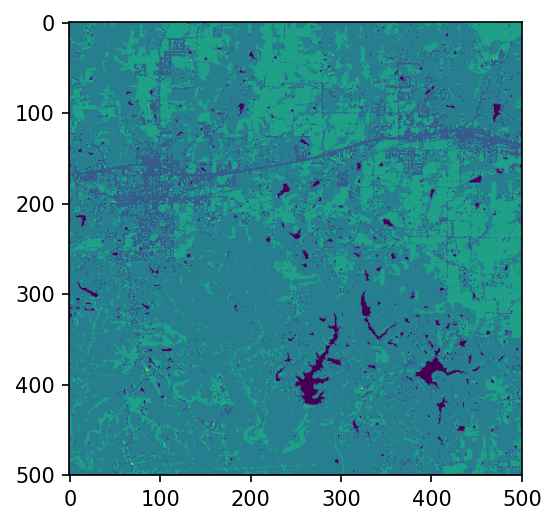

In [89]:
# Plot the image
plt.figure(dpi=150)
plt.imshow(lulc_2d)
plt.show()

In [90]:
# get the profile information of the main raster img_small
profile = src_small.profile
print(profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 501, 'height': 501, 'count': 7, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 658755.0,
       0.0, -30.0, 4303365.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


In [91]:

profile.update({'count': 1})

print(profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 501, 'height': 501, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 658755.0,
       0.0, -30.0, 4303365.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


In [93]:
# Now save it in the lab3 folder
with rasterio.open(r'C:\Users\syed_\OneDrive - Saint Louis University\Intro To Prog\lab3\LULC4.tif', 'w', **profile) as dst:
    dst.write(lulc_2d.astype(rasterio.uint16), 1)

# Deliverables from Part 2

* The completed notebook named <code>a3_tour_of_scikitlearn_algorithms_Part2_STUDENT.ipynb</code> (change the STUDENT with your surname or SLU net id)
* A Microsoft Word Document (.docx) file where you have a table with different models, hyperparameters and test scores (The template of the table is given in **Part 1 Task 10**)
* A JPG map of LULC2.tif created in ArcGIS Desktop or ArcGIS Pro (or any geospatial software of your liking), where you provide map title, legends, north arrow, scale bar etc.